In [1]:
import pandas as pd
import os
import numpy as np
import epiweeks
import datetime
import requests
import zipfile
import csv
from contextlib import ExitStack
import progressbar as pbar
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
import warnings
from itertools import product
warnings.filterwarnings('ignore')
from scipy import optimize

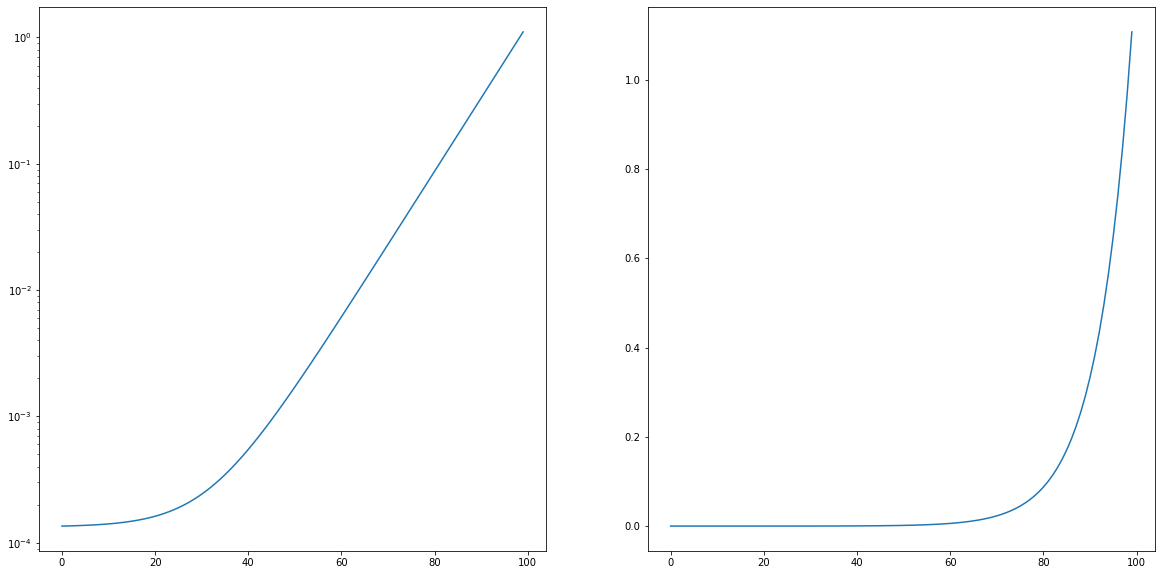

{'00-04': 0.01361492329627214,
 '05-09': 0.013863158048339912,
 '10-14': 0.014351433389615564,
 '15-19': 0.015318414597000047,
 '20-24': 0.017172694428108072,
 '25-29': 0.02085916327644466,
 '30-34': 0.0277882887719566,
 '35-39': 0.04166140346321195,
 '40-44': 0.06828969617851055,
 '45-49': 0.12276795676298914,
 '50-54': 0.22477464678936046,
 '55-59': 0.4206373412420534,
 '60-64': 0.8055954392660122,
 '65-69': 1.5666980229598073,
 '70-74': 2.968740787064521,
 '75-79': 6.029670019396245,
 '80-84': 11.285636750229425,
 '85+': 30.80480683989677,
 'TOTAL': 1.0790591339421733}

In [2]:
today = datetime.date.today().strftime("%d-%m-%Y")
data_dir_path = f'data/World/{today}'

IFRs = {'O\'Driscoll': {'00-34': [0.009, 0.007, 0.010],
                        '35-59': [0.122, 0.115, 0.128],
                        '60-79': [0.992, 0.942, 1.045],
                        '80+': [7.274, 6.909, 7.656],
                        'TOTAL': [0.756, 0.717, 0.796]},
        'Verity': {'00-34': [0.041, 0.019, 0.110],
                   '35-59': [0.349, 0.194, 0.743],
                   '60-79': [2.913, 1.670, 5.793],
                   '80+': [7.800, 3.800, 13.30],
                   'TOTAL': [1.296, 0.694, 2.453]},
        'Perez-Saez': {'00-34': [0.007, 0.003, 0.013],
                       '35-59': [0.070, 0.047, 0.097],
                       '60-79': [3.892, 2.985, 5.145],
                       '80+': [5.600, 4.300, 7.400],
                       'TOTAL': [1.254, 0.959, 0.661]},
        'Levin': {'00-34': [0.016, 0.014, 0.020],
                  '35-59': [0.226, 0.212, 0.276],
                  '60-79': [2.491, 2.294, 3.266],
                  '80+': [15.61, 12.20, 19.50],
                  'TOTAL': [1.687, 1.407, 2.139]}}

population = pd.read_csv(f'{data_dir_path}/Germany/old_population.csv')
population = population[~population['Age group'].isin(['UNK', 'Y_OPEN'])]
population = population[population['Region'] == 'DE']
population['Age group'] = population['Age group'].replace({'TOTAL': 'YTOTAL', 'Y_LT1': 'Y0'}).apply(lambda x: x[1:])
population = population[~population['Age group'].isin(['TOTAL'])]
population = population[population['Year'] == 2020]
population = population[population['Sex'] == 'T']
population['Age group'] = population['Age group'].apply(lambda x: int(x))
population = population.drop(columns=['Region', 'Year', 'Sex']).set_index('Age group').sort_index()

T = population.to_numpy()
def func(x, a, b, c):
    x1, x2 = x
    P = np.zeros(len(x1))
    for j in range(len(x1)):
        for i in range(int(x1[j]), int(x2[j])):
            P[j] += T[i] / np.sum(T[int(x1[j]): int(x2[j])]) * (np.exp(a*i + b) + c)
            
    return P

x1 = np.array(4 * [0, 35, 60])
x2 = np.array(4 * [35, 60, 80])
y = np.array([IFRs['O\'Driscoll']['00-34'][0] / 100,
              IFRs['O\'Driscoll']['35-59'][0] / 100,
              IFRs['O\'Driscoll']['60-79'][0] / 100,
              # IFRs['O\'Driscoll']['80+'][0] / 100,
              # IFRs['O\'Driscoll']['TOTAL'][0] / 100,
              IFRs['Verity']['00-34'][0] / 100,
              IFRs['Verity']['35-59'][0] / 100,
              IFRs['Verity']['60-79'][0] / 100,
              # IFRs['Verity']['80+'][0] / 100,
              # IFRs['Verity']['TOTAL'][0] / 100,
              IFRs['Perez-Saez']['00-34'][0] / 100,
              IFRs['Perez-Saez']['35-59'][0] / 100,
              IFRs['Perez-Saez']['60-79'][0] / 100,
              # IFRs['Perez-Saez']['80+'][0] / 100,
              # IFRs['Perez-Saez']['TOTAL'][0] / 100,
              IFRs['Levin']['00-34'][0] / 100,
              IFRs['Levin']['35-59'][0] / 100,
              IFRs['Levin']['60-79'][0] / 100,
              # IFRs['Levin']['80+'][0] / 100,
              # IFRs['Levin']['TOTAL'][0] / 100,
             ])
alpha, *rest = optimize.curve_fit(func, xdata = (x1, x2), ydata = y)

age = np.arange(0, 100)
ifr = np.exp(alpha[0]*age + alpha[1]) + np.abs(alpha[2])

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(age, ifr)
ax[0].set_yscale('log')
ax[1].plot(age, ifr)
plt.show()

est_IFR = {}
age_group = 5
for start, stop in zip(range(0, 80 + 1, age_group), range(5, 85 + 1, age_group)):
    P = 0.0
    for i in range(start, stop):
        P += T[i] / np.sum(T[start: stop]) * (np.exp(alpha[0]*i + alpha[1]) + np.abs(alpha[2]))
    est_IFR[f'{start:02d}-{(stop - 1):02d}'] = float(P) * 100.0
P = 0.0
for i in range(85, 100):
    P += T[i] / np.sum(T[85: ]) * (np.exp(alpha[0]*i + alpha[1]) + np.abs(alpha[2]))
est_IFR[f'85+'] = float(P) * 100.0

P = 0.0
for i in range(0, 85):
    P += T[i] / np.sum(T) * (np.exp(alpha[0]*i + alpha[1]) + np.abs(alpha[2]))
est_IFR[f'TOTAL'] = float(P) * 100.0

with open(f'{data_dir_path}/ifr_5_years_age_group.json', 'w') as file:
    json.dump(est_IFR, file, indent=4)
est_IFR

In [3]:
rest

[array([[ 2.12269375e-02, -1.56358050e+00,  3.94618416e-04],
        [-1.56358050e+00,  1.15203722e+02, -2.93424728e-02],
        [ 3.94618416e-04, -2.93424728e-02,  1.39292125e-05]])]

In [4]:
est_IFR = {}
with open(f'{data_dir_path}/eurostat_countries.json', 'r') as file:
    countries = json.load(file)
    
for country, region in countries.items():
    if country in ['Andorra', 'Bosnia and Herzegovina', 'Belarus', 'Monaco', 'Moldova', 'Russia', 'San Marino']:
        continue
    est_IFR[country] = {}
    
    population = pd.read_csv(f'{data_dir_path}/{country}/old_population.csv')
    
    population = population[~population['Age group'].isin(['UNK', 'Y_OPEN'])]
    population = population[population['Region'] == region]
    population['Age group'] = population['Age group'].replace({'TOTAL': 'YTOTAL', 'Y_LT1': 'Y0'}).apply(lambda x: x[1:])
    population = population[~population['Age group'].isin(['TOTAL'])]
    if country == 'United Kingdom':
        population = population[population['Year'] == 2019]
    else:
        population = population[population['Year'] == 2020]
    population = population[population['Sex'] == 'T']
    population['Age group'] = population['Age group'].apply(lambda x: int(x))
    population = population.drop(columns=['Region', 'Year', 'Sex']).set_index('Age group').sort_index()
    # print(country, region, len(population))
    T = population.to_numpy()
    if country != 'Poland':
        for start, stop in zip([0, 50, 55, 60, 65, 70, 75, 50], [50, 55, 60, 65, 70, 75, 80, 65]):
            P = 0.0
            for i in range(start, stop):
                P += T[i] / np.sum(T[start: stop]) * (np.exp(alpha[0]*i + alpha[1]) + np.abs(alpha[2]))
            est_IFR[country][f'{start:02d}-{(stop - 1):02d}'] = float(P) * 100.0
    else:
        for start, stop in zip([0, 45, 55, 65, 75, 45], [45, 55, 65, 75, 85, 65]):
            P = 0.0
            for i in range(start, stop):
                P += T[i] / np.sum(T[start: stop]) * (np.exp(alpha[0]*i + alpha[1]) + np.abs(alpha[2]))
            est_IFR[country][f'{start:02d}-{(stop - 1):02d}'] = float(P) * 100.0
            
    P = 0.0
    for i in range(0, 85):
        P += T[i] / np.sum(T) * (np.exp(alpha[0]*i + alpha[1]) + np.abs(alpha[2]))
    est_IFR[country][f'TOTAL'] = float(P) * 100.0
    P = 0.0
    for i in range(50, 85):
        P += T[i] / np.sum(T[50: 85]) * (np.exp(alpha[0]*i + alpha[1]) + np.abs(alpha[2]))
    est_IFR[country][f'50+'] = float(P) * 100.0
    P = 0.0
    for i in range(80, 85):
        P += T[i] / np.sum(T[80: 85]) * (np.exp(alpha[0]*i + alpha[1]) + np.abs(alpha[2]))
    est_IFR[country][f'80+'] = float(P) * 100.0
    
pd.DataFrame(est_IFR).to_excel(f'{data_dir_path}/ifr_all_country.xlsx')
with open(f'{data_dir_path}/ifr_5_years_age_group.json', 'w') as file:
    json.dump(est_IFR, file, indent=4)

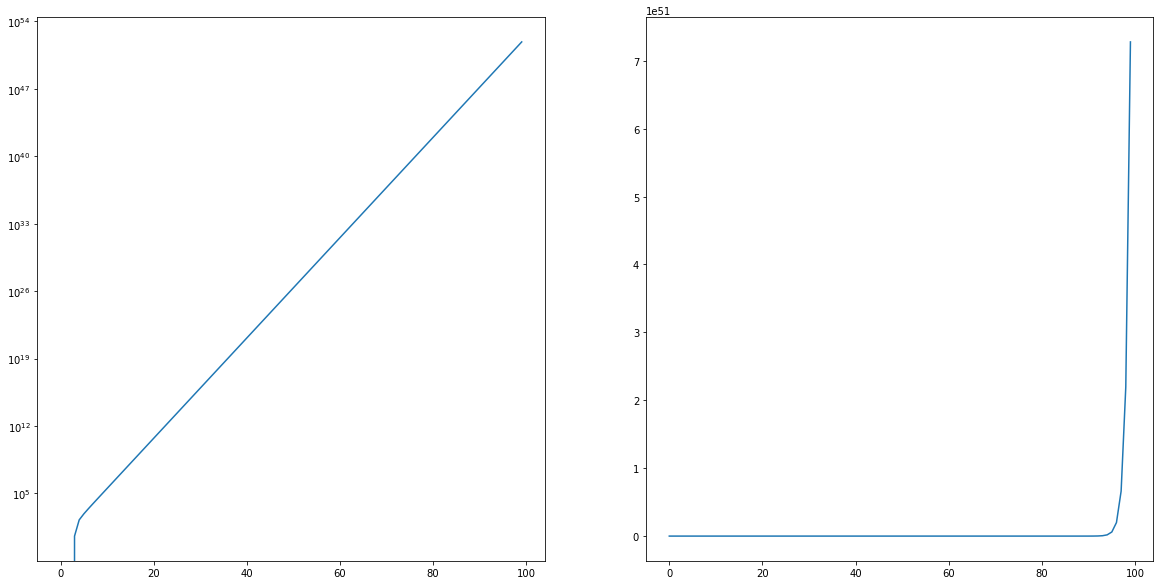

{'00-04': 0.013615708900450833,
 '05-09': 0.013863948972244355,
 '10-14': 0.014352234313354695,
 '15-19': 0.01531923439513793,
 '20-24': 0.017173548656251366,
 '25-29': 0.02086008242703529,
 '30-34': 0.027789323425911495,
 '35-39': 0.0416626562185039,
 '40-44': 0.068291342276269,
 '45-49': 0.1227703549944709,
 '50-54': 0.22477835595973722,
 '55-59': 0.42064338425976955,
 '60-64': 0.8056057068425191,
 '65-69': 1.566715917194553,
 '70-74': 2.968771424476299,
 '75-79': 6.029725491193629,
 '80-84': 11.285729928011264,
 '85+': 30.805011621547035,
 'TOTAL': 1.0790699455984007}

In [9]:
today = datetime.date.today().strftime("%d-%m-%Y")
data_dir_path = f'data/World/{today}'

IFRs = {'O\'Driscoll': {'00-34': [0.009, 0.007, 0.010],
                        '35-59': [0.122, 0.115, 0.128],
                        '60-79': [0.992, 0.942, 1.045],
                        '80+': [7.274, 6.909, 7.656],
                        'TOTAL': [0.756, 0.717, 0.796]},
        'Verity': {'00-34': [0.041, 0.019, 0.110],
                   '35-59': [0.349, 0.194, 0.743],
                   '60-79': [2.913, 1.670, 5.793],
                   '80+': [7.800, 3.800, 13.30],
                   'TOTAL': [1.296, 0.694, 2.453]},
        'Perez-Saez': {'00-34': [0.007, 0.003, 0.013],
                       '35-59': [0.070, 0.047, 0.097],
                       '60-79': [3.892, 2.985, 5.145],
                       '80+': [5.600, 4.300, 7.400],
                       'TOTAL': [1.254, 0.959, 0.661]},
        'Levin': {'00-34': [0.016, 0.014, 0.020],
                  '35-59': [0.226, 0.212, 0.276],
                  '60-79': [2.491, 2.294, 3.266],
                  '80+': [15.61, 12.20, 19.50],
                  'TOTAL': [1.687, 1.407, 2.139]}}

population = pd.read_csv(f'{data_dir_path}/Germany/old_population.csv')
population = population[~population['Age group'].isin(['UNK', 'Y_OPEN'])]
population = population[population['Region'] == 'DE']
population['Age group'] = population['Age group'].replace({'TOTAL': 'YTOTAL', 'Y_LT1': 'Y0'}).apply(lambda x: x[1:])
population = population[~population['Age group'].isin(['TOTAL'])]
population = population[population['Year'] == 2020]
population = population[population['Sex'] == 'T']
population['Age group'] = population['Age group'].apply(lambda x: int(x))
population = population.drop(columns=['Region', 'Year', 'Sex']).set_index('Age group').sort_index()

T = population.to_numpy()
def ifr_func(x, alpha):
    return np.power(alpha[0], alpha[1]*x + alpha[2]) + alpha[3]
def func(x, a, b, c, d):
    x1, x2 = x
    P = np.zeros(len(x1))
    for j in range(len(x1)):
        for i in range(int(x1[j]), int(x2[j])):
            P[j] += T[i] / np.sum(T[int(x1[j]): int(x2[j])]) * ifr_func(i, [a, b, c, d])
            
    return P

x1 = np.array(4 * [0, 35, 60])
x2 = np.array(4 * [35, 60, 80])
y = np.array([IFRs['O\'Driscoll']['00-34'][0] / 100,
              IFRs['O\'Driscoll']['35-59'][0] / 100,
              IFRs['O\'Driscoll']['60-79'][0] / 100,
              # IFRs['O\'Driscoll']['80+'][0] / 100,
              # IFRs['O\'Driscoll']['TOTAL'][0] / 100,
              IFRs['Verity']['00-34'][0] / 100,
              IFRs['Verity']['35-59'][0] / 100,
              IFRs['Verity']['60-79'][0] / 100,
              # IFRs['Verity']['80+'][0] / 100,
              # IFRs['Verity']['TOTAL'][0] / 100,
              IFRs['Perez-Saez']['00-34'][0] / 100,
              IFRs['Perez-Saez']['35-59'][0] / 100,
              IFRs['Perez-Saez']['60-79'][0] / 100,
              # IFRs['Perez-Saez']['80+'][0] / 100,
              # IFRs['Perez-Saez']['TOTAL'][0] / 100,
              IFRs['Levin']['00-34'][0] / 100,
              IFRs['Levin']['35-59'][0] / 100,
              IFRs['Levin']['60-79'][0] / 100,
              # IFRs['Levin']['80+'][0] / 100,
              # IFRs['Levin']['TOTAL'][0] / 100,
             ])
alpha = optimize.curve_fit(func, xdata = (x1, x2), ydata = y, maxfev = 100000000)[0]
alpha[3] = np.abs(alpha[3])
age = np.arange(0, 100)
ifr = np.exp(alpha[0]*age + alpha[1]) + alpha[2]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(age, ifr)
ax[0].set_yscale('log')
ax[1].plot(age, ifr)
plt.show()

est_IFR = {}
age_group = 5
for start, stop in zip(range(0, 80 + 1, age_group), range(5, 85 + 1, age_group)):
    P = 0.0
    for i in range(start, stop):
        P += T[i] / np.sum(T[start: stop]) * ifr_func(i, alpha)
    est_IFR[f'{start:02d}-{(stop - 1):02d}'] = float(P) * 100.0
P = 0.0
for i in range(85, 100):
    P += T[i] / np.sum(T[85: ]) * ifr_func(i, alpha)
est_IFR[f'85+'] = float(P) * 100.0

P = 0.0
for i in range(0, 85):
    P += T[i] / np.sum(T) * ifr_func(i, alpha)
est_IFR[f'TOTAL'] = float(P) * 100.0

with open(f'{data_dir_path}/ifr_5_years_age_group_v2.json', 'w') as file:
    json.dump(est_IFR, file, indent=4)
est_IFR

In [8]:
est_IFR = {}
with open(f'{data_dir_path}/eurostat_countries.json', 'r') as file:
    countries = json.load(file)
    
for country, region in countries.items():
    if country in ['Andorra', 'Bosnia and Herzegovina', 'Belarus', 'Monaco', 'Moldova', 'Russia', 'San Marino']:
        continue
    est_IFR[country] = {}
    
    population = pd.read_csv(f'{data_dir_path}/{country}/old_population.csv')
    
    population = population[~population['Age group'].isin(['UNK', 'Y_OPEN'])]
    population = population[population['Region'] == region]
    population['Age group'] = population['Age group'].replace({'TOTAL': 'YTOTAL', 'Y_LT1': 'Y0'}).apply(lambda x: x[1:])
    population = population[~population['Age group'].isin(['TOTAL'])]
    if country == 'United Kingdom':
        population = population[population['Year'] == 2019]
    else:
        population = population[population['Year'] == 2020]
    population = population[population['Sex'] == 'T']
    population['Age group'] = population['Age group'].apply(lambda x: int(x))
    population = population.drop(columns=['Region', 'Year', 'Sex']).set_index('Age group').sort_index()
    # print(country, region, len(population))
    T = population.to_numpy()
    if country != 'Poland':
        for start, stop in zip([0, 50, 55, 60, 65, 70, 75, 50], [50, 55, 60, 65, 70, 75, 80, 65]):
            P = 0.0
            for i in range(start, stop):
                P += T[i] / np.sum(T[start: stop]) * ifr_func(i, alpha)
            est_IFR[country][f'{start:02d}-{(stop - 1):02d}'] = float(P) * 100.0
    else:
        for start, stop in zip([0, 45, 55, 65, 75, 45], [45, 55, 65, 75, 85, 65]):
            P = 0.0
            for i in range(start, stop):
                P += T[i] / np.sum(T[start: stop]) * ifr_func(i, alpha)
            est_IFR[country][f'{start:02d}-{(stop - 1):02d}'] = float(P) * 100.0
            
    P = 0.0
    for i in range(0, 85):
        P += T[i] / np.sum(T) * ifr_func(i, alpha)
    est_IFR[country][f'TOTAL'] = float(P) * 100.0
    P = 0.0
    for i in range(50, 85):
        P += T[i] / np.sum(T[50: 85]) * ifr_func(i, alpha)
    est_IFR[country][f'50+'] = float(P) * 100.0
    P = 0.0
    for i in range(80, 85):
        P += T[i] / np.sum(T[80: 85]) * ifr_func(i, alpha)
    est_IFR[country][f'80+'] = float(P) * 100.0
    
pd.DataFrame(est_IFR).to_excel(f'{data_dir_path}/ifr_all_country.xlsx')
with open(f'{data_dir_path}/ifr_5_years_age_group.json', 'w') as file:
    json.dump(est_IFR, file, indent=4)
est_IFR

{'Albania': {'00-49': 0.2793710985170528,
  '50-54': 0.787904919388302,
  '55-59': 1.101095179447921,
  '60-64': 1.5580600456245106,
  '65-69': 2.241795691487749,
  '70-74': 3.2733952578721457,
  '75-79': 4.8731760168860765,
  '50-64': 1.145117813396721,
  'TOTAL': 0.9458768594658409,
  '50+': 2.214168911452553,
  '80+': 7.0376320883324475},
 'Armenia': {'00-49': 0.2797171679560548,
  '50-54': 0.7921040904229711,
  '55-59': 1.1087193009150402,
  '60-64': 1.5562359389446387,
  '65-69': 2.248523715303491,
  '70-74': 3.241235007798922,
  '75-79': 5.068297389498112,
  '50-64': 1.1693480650369725,
  'TOTAL': 0.8577471065306692,
  '50+': 2.1738708751546403,
  '80+': 7.113966509935479},
 'Austria': {'00-49': 0.29764153319375264,
  '50-54': 0.789034971128603,
  '55-59': 1.097088615256591,
  '60-64': 1.5599654469692406,
  '65-69': 2.259442839483406,
  '70-74': 3.2686515574310606,
  '75-79': 4.906921953486362,
  '50-64': 1.1188303835399636,
  'TOTAL': 1.0838627842268054,
  '50+': 2.3573018032202